In [161]:
import numpy as np
import nibabel as nib
from dipy.viz import regtools
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import *
import matplotlib as plt
import pickle
import os

In [162]:
ID = '07'

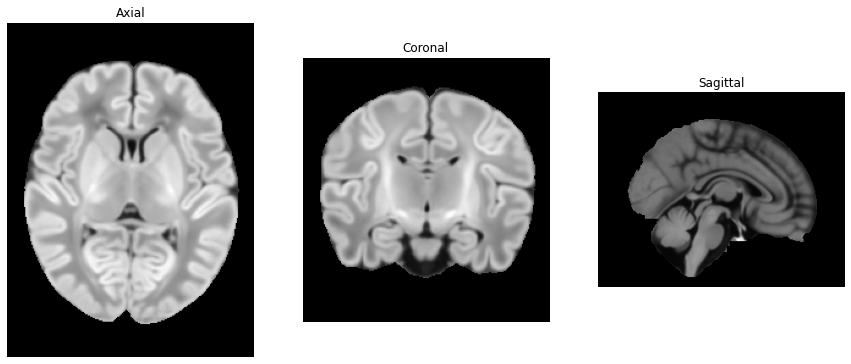

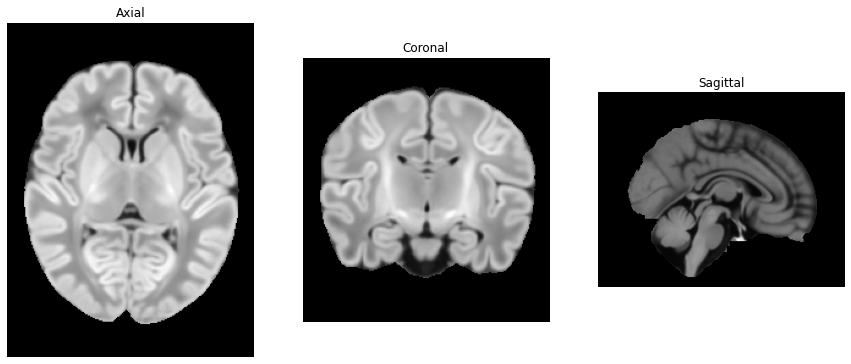

In [163]:
static_nii = nib.load("/home/magic-chusj-2/Desktop/Registration/dhcp-volumetric-atlas-groupwise/mean/ga_40/average_t1_masked.nii")
static = static_nii.get_fdata()
static_grid2world = static_nii.affine
regtools.plot_slices(static)

mask_atlas_nii = nib.load("/home/magic-chusj-2/Desktop/Registration/dhcp-volumetric-atlas-groupwise/mean/ga_40/erodedMask.nii")
mask_atlas = mask_atlas_nii.get_fdata().astype(bool)
static[~mask_atlas] = 0

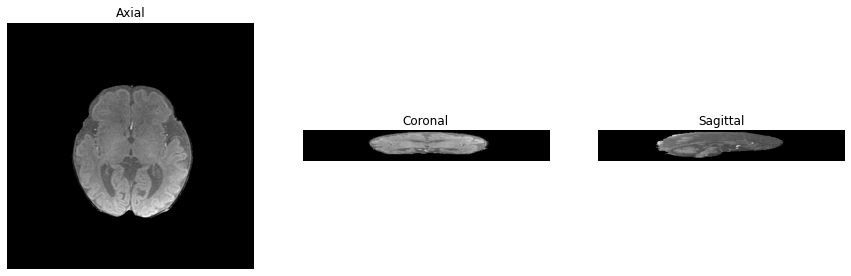

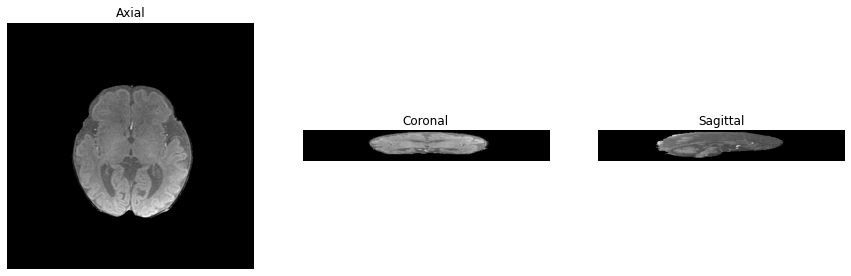

In [164]:
moving_nii = nib.load("/home/magic-chusj-2/Desktop/QSM/QSM.m/Results/HIE_baby_0"+ID+"/magMask.nii")
moving = moving_nii.get_fdata()
moving_grid2world = moving_nii.affine

# Rotation de la matrice affine
# ort = np.array([[0, 1], [1, -1], [2, 1]])
# moving_grid2world = moving_nii.as_reoriented(ornt).affine
regtools.plot_slices(moving)

mask_nii = nib.load('/home/magic-chusj-2/Desktop/QSM/QSM.m/Results/mask0_right.nii')
mask = mask_nii.get_fdata().astype(bool)
moving[~mask] = 0
regtools.plot_slices(moving)

In [165]:
identity = np.eye(4)
affine_map = AffineMap(identity, static.shape, static_grid2world, moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)

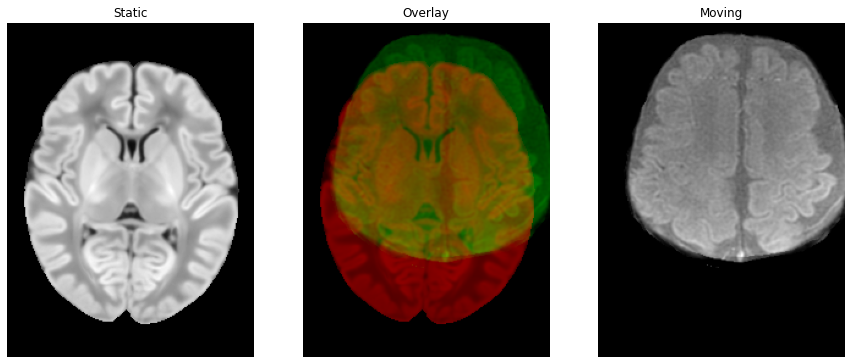

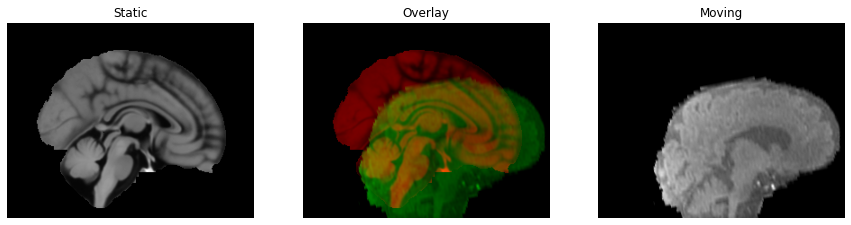

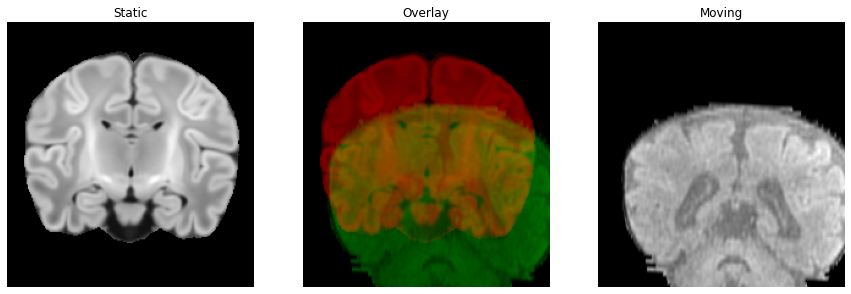

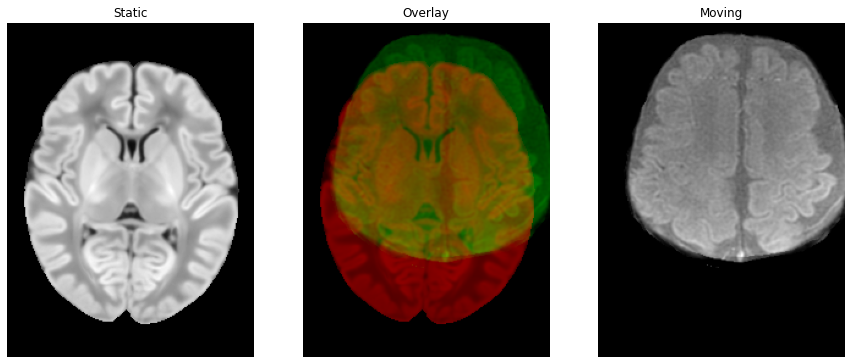

In [166]:
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving")

In [167]:
c_of_mass = transform_centers_of_mass(static, static_grid2world, moving, moving_grid2world)

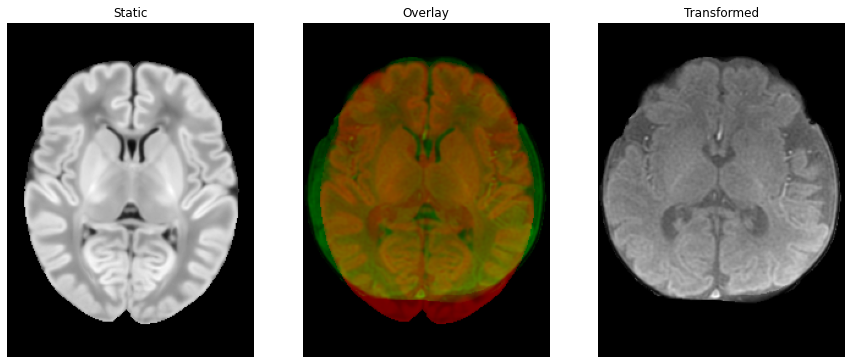

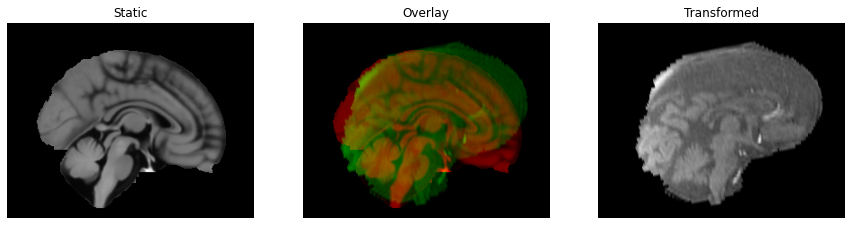

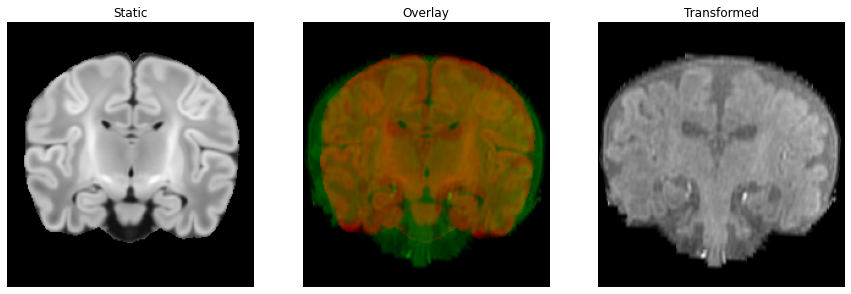

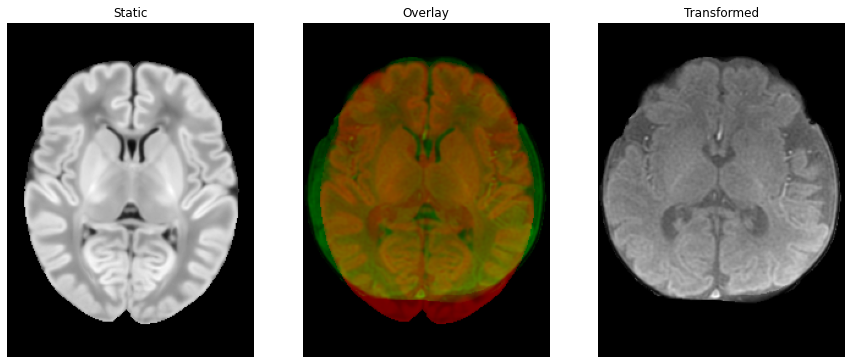

In [168]:
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed")

In [169]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [170]:
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,level_iters=level_iters,sigmas=sigmas,factors=factors)

In [171]:
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,static_grid2world, moving_grid2world, starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


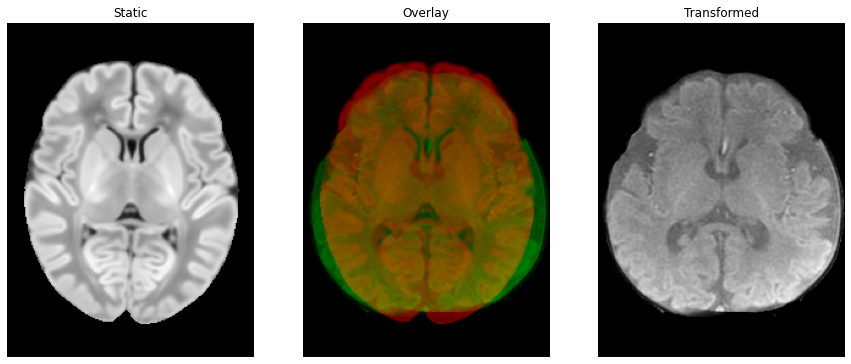

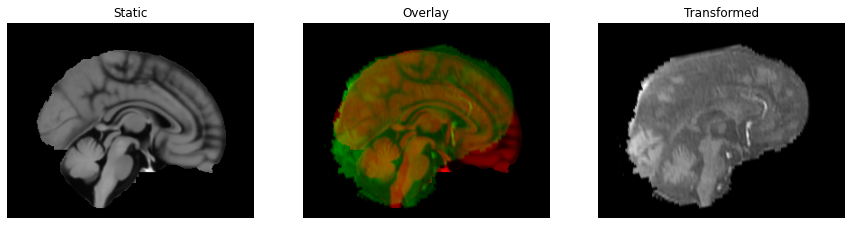

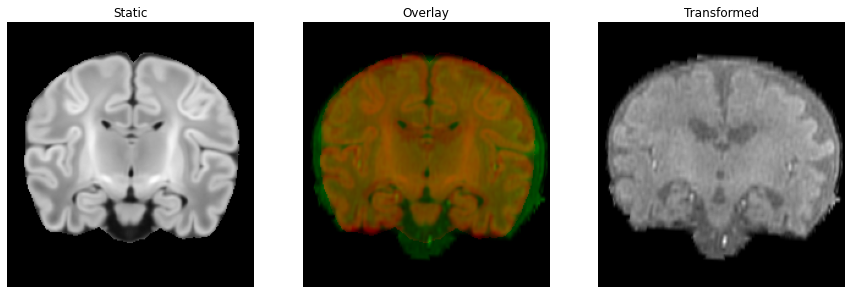

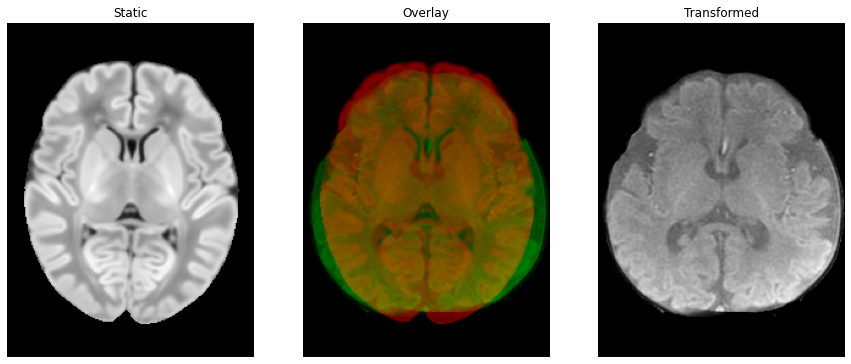

In [172]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed")

In [173]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


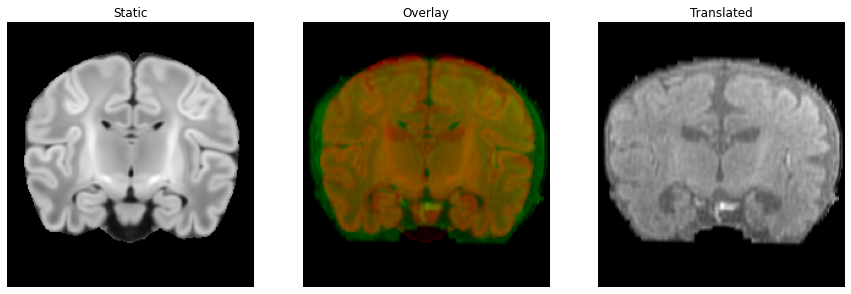

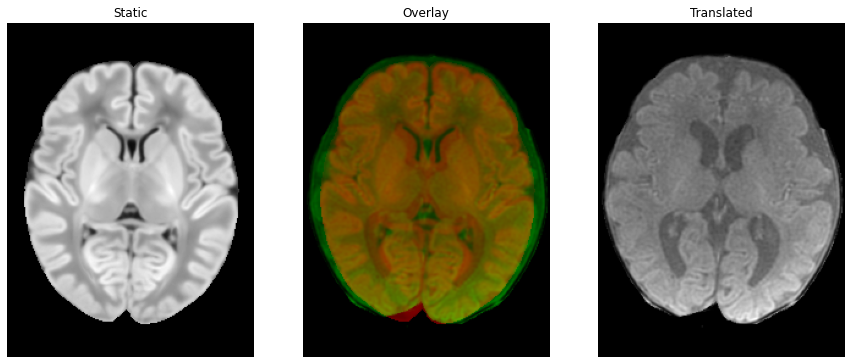

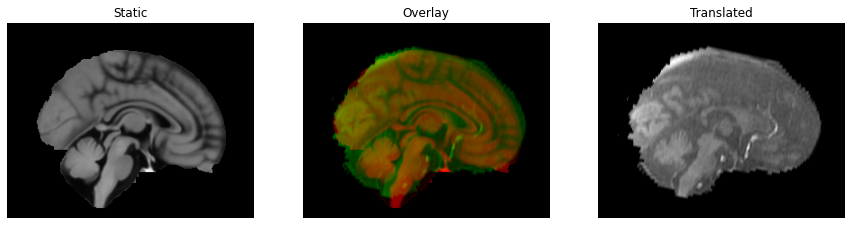

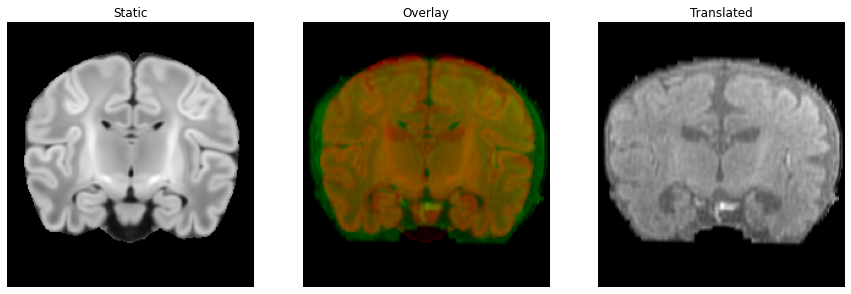

In [174]:
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Translated")
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Translated")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Translated")


In [175]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


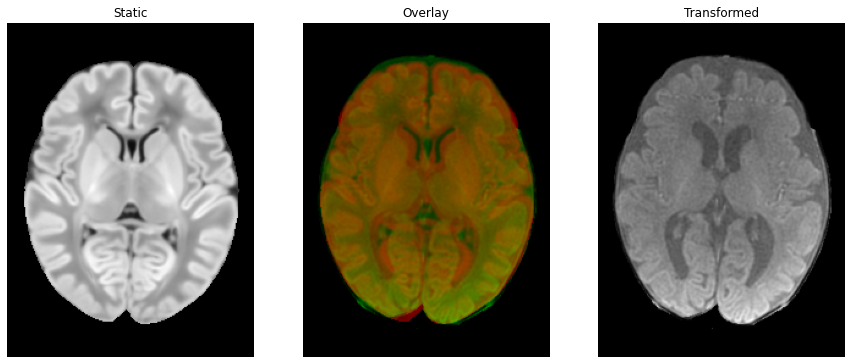

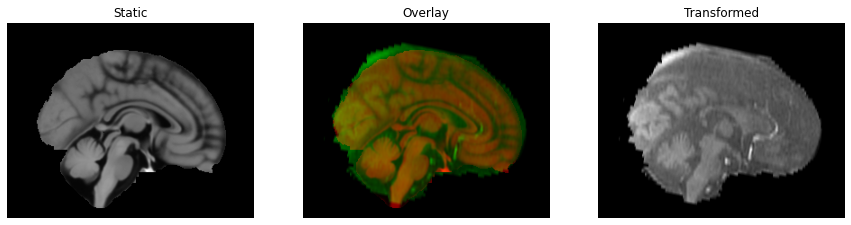

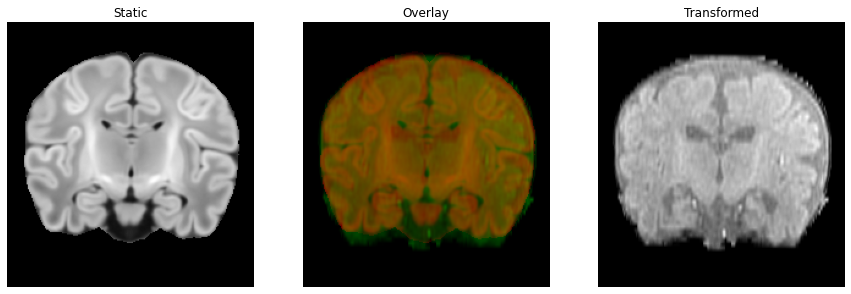

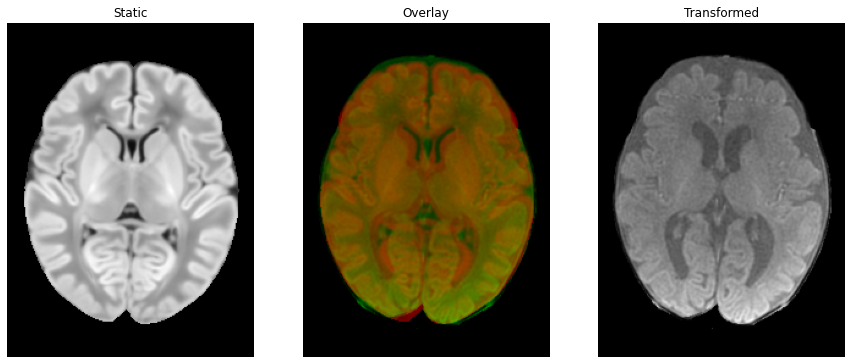

In [176]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed")

In [177]:
metric = CCMetric(3, sigma_diff = 5)
level_iters = [10,10,5] #Default [10, 10, 5]
# sigma = 1 # Default 0.2
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

In [178]:
mapping = sdr.optimize(static, moving, static_grid2world, moving_grid2world, affine.affine)

In [179]:
warped_moving = mapping.transform(moving)

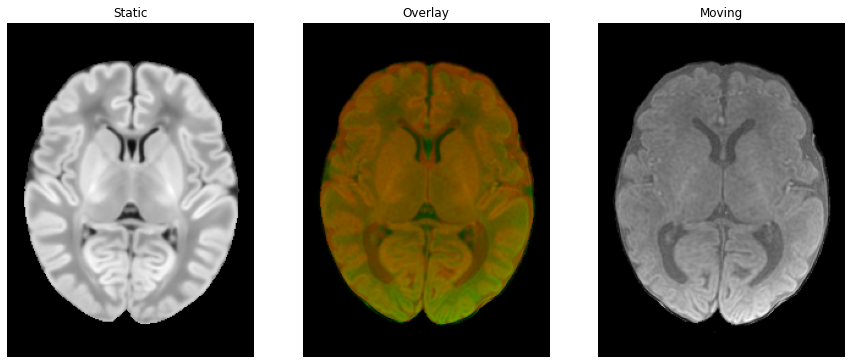

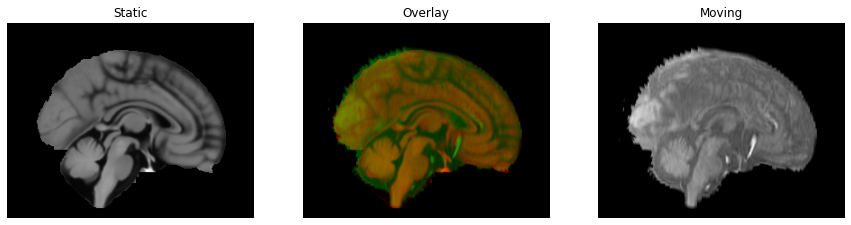

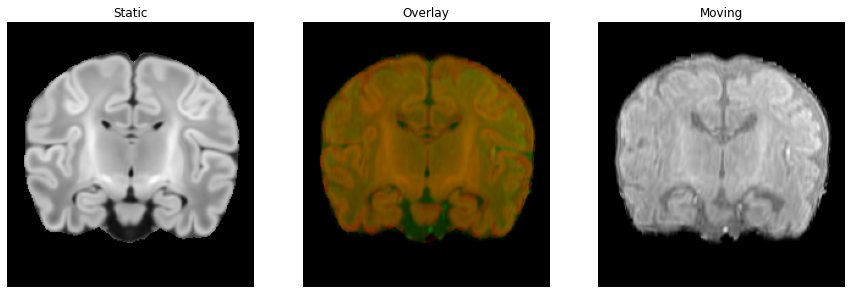

In [180]:
plt.rcParams["figure.figsize"] = (15, 10)
regtools.overlay_slices(static, warped_moving, None, 2,"Static", "Moving")
regtools.overlay_slices(static, warped_moving, None, 0,"Static", "Moving")
regtools.overlay_slices(static, warped_moving, None, 1,"Static", "Moving");


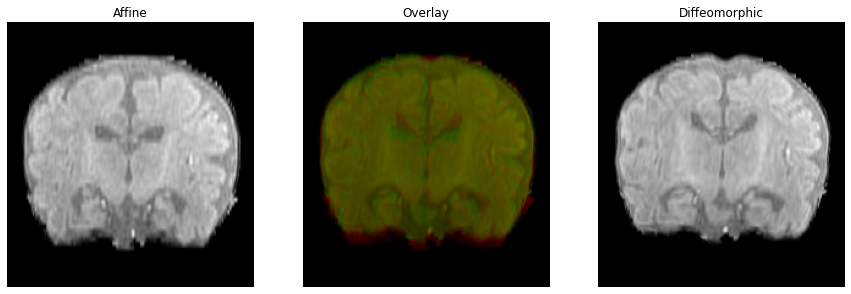

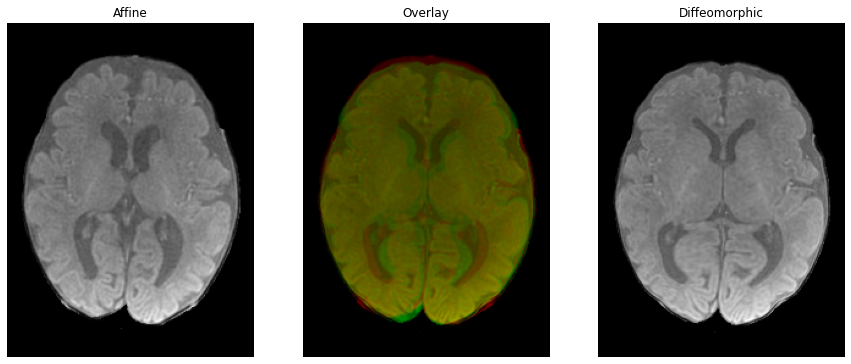

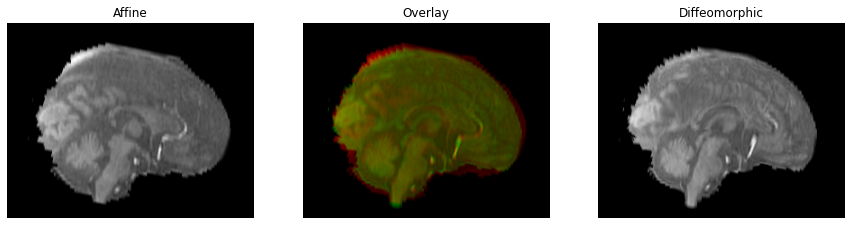

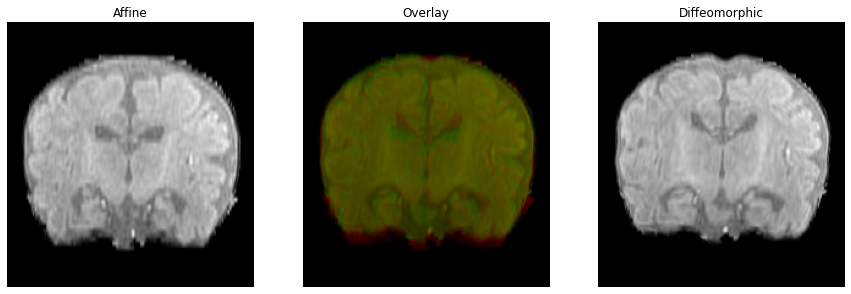

In [181]:
regtools.overlay_slices(transformed, warped_moving, None, 2,"Affine", "Diffeomorphic")
regtools.overlay_slices(transformed, warped_moving, None, 0,"Affine", "Diffeomorphic")
regtools.overlay_slices(transformed, warped_moving, None, 1, "Affine", "Diffeomorphic")


In [182]:
outputpath = '/home/magic-chusj-2/Desktop/Registration/results/dipy/HIE_baby_0'+ID
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
img = nib.Nifti1Image(warped_moving, static_nii.affine, header =static_nii.header )
nib.save(img, os.path.join(outputpath,"registered_mag"))

In [183]:
#Saving dipy.align.imwarp.DiffeomorphicMap in file
with open(os.path.join(outputpath,'transformation.pkl'), 'wb') as f:
    pickle.dump(mapping, f)

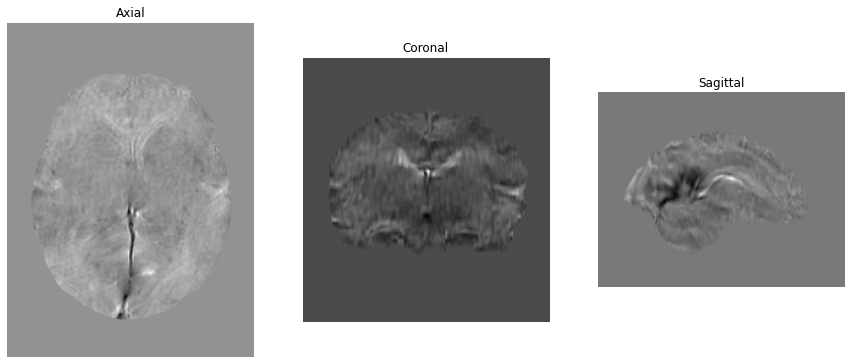

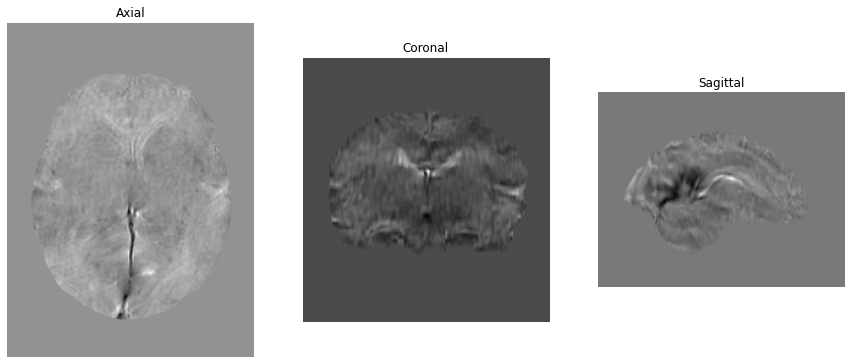

In [184]:
# Apply transformation to QSM image
qsm_nii = nib.load("/home/magic-chusj-2/Desktop/QSM/QSM.m/Results/HIE_baby_0"+ID+"/resharp_rts/chi.nii")
qsm = qsm_nii.get_fdata()

warped_qsm = mapping.transform(qsm)
regtools.plot_slices(warped_qsm)

In [ ]:
img = nib.Nifti1Image(warped_qsm, static_nii.affine, header =static_nii.header )
nib.save(img, os.path.join(outputpath,"registered_qsm"))

trans = pickle.load(open('/home/magic-chusj-2/Desktop/Registration/results/dipy/HIE_baby_023/transformation.pkl','rb'))
qsm_nii = nib.load("/home/magic-chusj-2/Desktop/QSM/QSM.m/Results/HIE_baby_023/resharp_rts/chi.nii")
qsm = qsm_nii.get_fdata()

warped_qsm = trans.transform(qsm)
regtools.plot_slices(warped_qsm)
img = nib.Nifti1Image(warped_qsm, static_nii.affine, header =static_nii.header )
nib.save(img, "/home/magic-chusj-2/Desktop/Registration/results/dipy/HIE_baby_023/registered_qsm.nii")